In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tidy3d as td
import tidy3d.web as web

In [2]:
# Define Paramters
# radius and location of the sphere
radius_Al2O3 = 0.25
radius_SiO2 = 4 # exp is 6um
box_size_xy = 10
box_size_z = 50

vol_Al2O3 = 4/3 * np.pi * np.power(radius_Al2O3,3)
vol_SiO2 = 4/3 * np.pi * np.power(radius_SiO2,3)
vol_box = box_size_xy * box_size_xy * box_size_z
num_Al2O3 = int(np.floor(0.2 * vol_box / vol_Al2O3))   # 20% of volumn is Al2O3
num_SiO2 = int(np.floor(0.3 * vol_box / vol_SiO2))   # 30% of volumn is SiO2
print('num_Al2O3',num_Al2O3)
print('num_SiO2',num_SiO2)

center = [0, 0, 0]

# permittivity of the Al2O3 sphere 
eps_Al2O3 = 3.0625
eps_SiO2 = 2.1316

# free space central wavelength
wl_start = 0.3  # wavelength
wl_end = 2.5  # wavelength
freq_start = td.C_0 / wl_end
freq_end = td.C_0 / wl_start

freqs = np.linspace(freq_start, freq_end, 100)  # freqeucny range of the simulation
freq0 = (freq_start + freq_end)/2  # central frequency
freqw = freq_end - freq_start  # width of the frequency range
print('freq0:',freq0)

lda0 = td.C_0 / freq0
print('lda0:',lda0)

# distance between the surface of the sphere and the start of the PML layers along each cartesian direction
buffer_PML = 2 * wl_end
buffer_source = 1 * wl_end

# Define material properties
air = td.Medium(permittivity=1)
Al2O3 = td.Medium(permittivity=eps_Al2O3)
SiO2 = td.Medium(permittivity=eps_SiO2)

# resolution control
min_steps_per_wvl = 20

# set the domain size in x, y, and z
domain_size_xy = box_size_xy 
domain_size_z = buffer_PML + box_size_z + buffer_PML

# construct simulation size array
sim_size = (domain_size_xy, domain_size_xy, domain_size_z)
print('sim_size:',sim_size)

num_Al2O3 15278
num_SiO2 5
freq0: 559612588266666.7
lda0: 0.5357142857142857
sim_size: (10, 10, 60.0)


In [3]:
# Create random structures
geometry = []
for i in range(num_SiO2):
    position_xy = (box_size_xy - 2*radius_SiO2) * (np.random.rand(2) - 0.5) 
    position_z = (box_size_z - 2*radius_SiO2) * (np.random.rand(1) - 0.5) 
    position = [position_xy[0],position_xy[1],position_z]
    sphere = td.Structure(geometry=td.Sphere(center=position, radius=radius_SiO2), medium=SiO2)
    geometry.append(sphere)
    
for i in range(num_Al2O3):
    position_xy = (box_size_xy - 2*radius_Al2O3) * (np.random.rand(2) - 0.5) 
    position_z = (box_size_z - 2*radius_Al2O3) * (np.random.rand(1) - 0.5)
    position = [position_xy[0],position_xy[1],position_z]
    sphere = td.Structure(geometry=td.Sphere(center=position, radius=radius_Al2O3), medium=Al2O3)
    geometry.append(sphere)    
    
geometry = tuple(geometry)
print('Geometry Finish')

Geometry Finish


In [4]:
# add a plane wave source
plane_wave = td.PlaneWave(
    source_time=td.GaussianPulse(freq0=freq0, fwidth=0.5 * freqw),
    size=(td.inf, td.inf, 0),
    center=(0, 0, box_size_z/2 + buffer_source),
    direction="-",
    pol_angle=0,
)

# add a flux monitor to detect transmission
monitor_t = td.FluxMonitor(
    center=[0, 0, -box_size_z/2 - (buffer_source+buffer_PML)/2], size=[td.inf, td.inf, 0], freqs=freqs, name="T"
)

# add a flux monitor to detect reflection
monitor_r = td.FluxMonitor(
    center=[0, 0, box_size_z/2 + (buffer_source+buffer_PML)/2], size=[td.inf, td.inf, 0], freqs=freqs, name="R"
)

# add a field monitor to see the field profile at the absorption peak frequency
monitor_field = td.FieldMonitor(
    center=[0, 0, 0], size=[td.inf, 0, box_size_z], freqs=[freq0], name="field"
)

print('Source and Monitor setup Finish')

Source and Monitor setup Finish


In [5]:
run_time = 1e-11  # simulation run time

# set up simulation
sim = td.Simulation(
    size=sim_size,
#     grid_spec=td.GridSpec.auto(min_steps_per_wvl=min_steps_per_wvl, wavelength=lda0), # Non uniform grip
    grid_spec=td.GridSpec.uniform(dl =lda0/20),
    structures=geometry,
    sources=[plane_wave],
    monitors=[monitor_t, monitor_r, monitor_field],
    run_time=run_time,
    boundary_spec=td.BoundarySpec(
        x=td.Boundary.periodic(), y=td.Boundary.periodic(), z=td.Boundary.pml()
    ), 
#     boundary_spec=td.BoundarySpec.all_sides(boundary=td.PML()),  # PML boundary
)  # symmetry can be used to greatly reduce the computational cost

print('Simulation setup Finish')

Simulation setup Finish


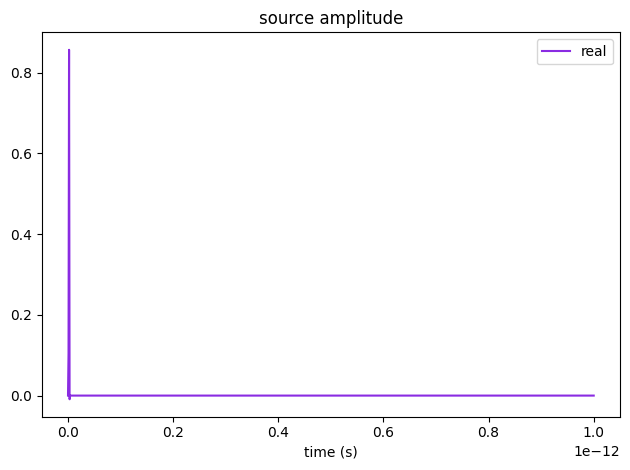

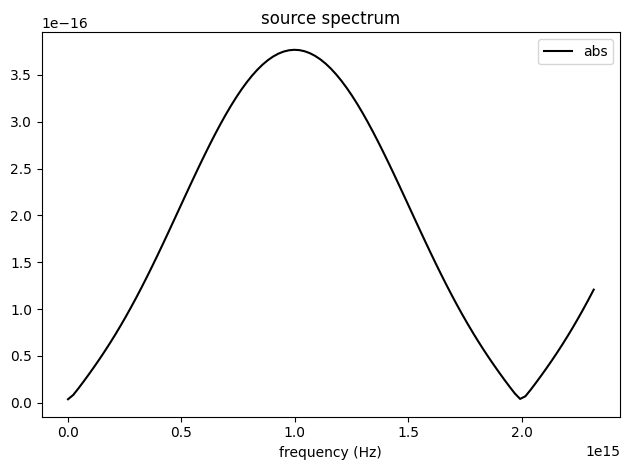

In [6]:
# Visualize source
plane_wave.source_time.plot(np.linspace(0, run_time/10, 1001))
plt.show()

plane_wave.source_time.plot_spectrum(
    times=np.linspace(0, run_time/10, 2000), val="abs"
)
plt.show()

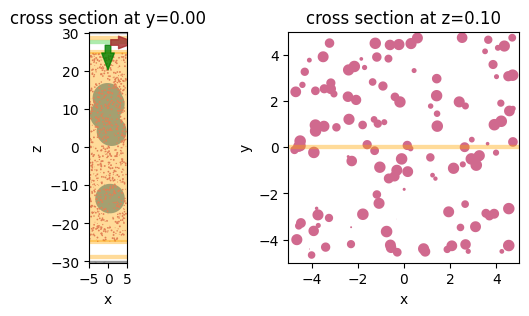

Visualize Source Finish


In [7]:
cfig, ax = plt.subplots(1, 2, figsize=(7, 3))
sim.plot(y=0, ax=ax[0])
sim.plot(z=0.1, freq=freq0, ax=ax[1])
plt.show()

print('Visualize Source Finish')

In [8]:
task_id = web.upload(sim, task_name="Simulation")
# print("Max flex unit cost: ", web.estimate_cost(task_id))

[09:18:26] Created task 'Simulation' with task_id 'fdve-71f236fe-9728-4a69-b9dc-6065ffbcdb5cv1'.      ]8;id=780123;file://C:\Users\54377\AppData\Roaming\Python\Python310\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=123855;file://C:\Users\54377\AppData\Roaming\Python\Python310\site-packages\tidy3d\web\webapi.py#186\186]8;;\

           View task using web UI at                                                                  ]8;id=266557;file://C:\Users\54377\AppData\Roaming\Python\Python310\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=531005;file://C:\Users\54377\AppData\Roaming\Python\Python310\site-packages\tidy3d\web\webapi.py#188\188]8;;\
           ]8;id=34864;https://tidy3d.simulation.cloud/workbench?taskId=fdve-71f236fe-9728-4a69-b9dc-6065ffbcdb5cv1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=190269;https://tidy3d.simulation.cloud/workbench?taskId=fdve-71f236fe-9728-4a69-b9dc-6065ffbcdb5cv1\taskId]8;;\]8;id=34864;https://tidy3d.simulation.cloud/workbench?taskId=fdve-71f236fe-9728-4a69-b9dc-6065ffbcdb5cv1\=]8;;\]8;id=697184;https://tidy3d.simulation.cloud/workbench?taskId=fdve-71f236fe-9728-4a69-b9dc-6065ffbcdb5cv1\fdve]8;;\]8;id=34864;https://tidy3d.simulation.cloud/workbench?taskId=fdve-71f236fe-9728-4a69-b9dc-6065ffbcdb5cv1\-71f236fe-9728-4a69-b9dc-6065ffbcdb5]8;;\              
           ]8;id=34864;https://tidy3d.simulation.cloud/workbench?taskId=fdve-71f236fe-9728-4a69-b9dc-6065ffbcdb5cv1\cv1']8;;\.                                                                                                   

C:\Users\54377\AppData\Roaming\Python\Python310\site-packages\rich\live.py:229: UserWarning: install "ipywidgets" 
for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

In [9]:
web.start(task_id)
web.monitor(task_id, verbose=True)

import time
time.sleep(4)
print("Billed flex unit cost: ", web.real_cost(task_id))

sim_data = web.load(task_id, path="data/cooling.hdf5")

# Show the output of the log file
print(sim_data.log)


# sim_data = sim.dict_from_hdf5(fname='data/cooling.hdf5')
# # print(sim_data)

# R = sim_data["R"].flux
# print(R)

[09:18:39] status = queued                                                                            ]8;id=272793;file://C:\Users\54377\AppData\Roaming\Python\Python310\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=939518;file://C:\Users\54377\AppData\Roaming\Python\Python310\site-packages\tidy3d\web\webapi.py#321\321]8;;\

[09:27:58] status = preprocess                                                                        ]8;id=903666;file://C:\Users\54377\AppData\Roaming\Python\Python310\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=252718;file://C:\Users\54377\AppData\Roaming\Python\Python310\site-packages\tidy3d\web\webapi.py#315\315]8;;\

[09:28:17] Maximum FlexCredit cost: 16.812. Use 'web.real_cost(task_id)' to get the billed FlexCredit ]8;id=621822;file://C:\Users\54377\AppData\Roaming\Python\Python310\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=270416;file://C:\Users\54377\AppData\Roaming\Python\Python310\site-packages\tidy3d\web\webapi.py#338\338]8;;\
           cost after a simulation run.                                                                            

           starting up solver                                                                         ]8;id=297293;file://C:\Users\54377\AppData\Roaming\Python\Python310\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=849423;file://C:\Users\54377\AppData\Roaming\Python\Python310\site-packages\tidy3d\web\webapi.py#342\342]8;;\

           running solver                                                                             ]8;id=202374;file://C:\Users\54377\AppData\Roaming\Python\Python310\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=179520;file://C:\Users\54377\AppData\Roaming\Python\Python310\site-packages\tidy3d\web\webapi.py#352\352]8;;\

[09:36:57] status = postprocess                                                                       ]8;id=864575;file://C:\Users\54377\AppData\Roaming\Python\Python310\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=179843;file://C:\Users\54377\AppData\Roaming\Python\Python310\site-packages\tidy3d\web\webapi.py#383\383]8;;\

[09:37:04] status = success                                                                           ]8;id=76583;file://C:\Users\54377\AppData\Roaming\Python\Python310\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=1577;file://C:\Users\54377\AppData\Roaming\Python\Python310\site-packages\tidy3d\web\webapi.py#390\390]8;;\

[09:37:09] WARNING: Billed FlexCredit for task 'fdve-71f236fe-9728-4a69-b9dc-6065ffbcdb5cv1' is not   ]8;id=499250;file://C:\Users\54377\AppData\Roaming\Python\Python310\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=322186;file://C:\Users\54377\AppData\Roaming\Python\Python310\site-packages\tidy3d\web\webapi.py#726\726]8;;\
           available. If the task has been successfully run, it should be available shortly.                       

Billed flex unit cost:  0.0


[09:37:17] loading SimulationData from data/cooling.hdf5                                              ]8;id=164424;file://C:\Users\54377\AppData\Roaming\Python\Python310\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=240016;file://C:\Users\54377\AppData\Roaming\Python\Python310\site-packages\tidy3d\web\webapi.py#568\568]8;;\

[09:37:19] WARNING: Simulation final field decay value of 0.00949 is greater than the simulation      ]8;id=582175;file://C:\Users\54377\AppData\Roaming\Python\Python310\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=488559;file://C:\Users\54377\AppData\Roaming\Python\Python310\site-packages\tidy3d\web\webapi.py#575\575]8;;\
           shutoff threshold of 1e-05. Consider simulation again with large run_time duration for                  
           more accurate results.                                                                                  

Simulation domain Nx, Ny, Nz: [374, 374, 2264]
Applied symmetries: (0, 0, 0)
Number of computational grid points: 3.1696e+08.
Using subpixel averaging: True
Number of time steps: 1.9605e+05
Automatic shutoff factor: 1.00e-05
Time step (s): 5.1008e-17


Compute source modes time (s):     7.6443
Compute monitor modes time (s):    0.3175
Rest of setup time (s):            18.7885

Running solver for 196048 time steps...
- Time step     35 / time 1.79e-15s (  0 % done), field decay: 1.00e+00
- Time step   7841 / time 4.00e-13s (  4 % done), field decay: 3.34e-01
- Time step  15683 / time 8.00e-13s (  8 % done), field decay: 2.58e-01
- Time step  23525 / time 1.20e-12s ( 12 % done), field decay: 2.24e-01
- Time step  31367 / time 1.60e-12s ( 16 % done), field decay: 1.95e-01
- Time step  39209 / time 2.00e-12s ( 20 % done), field decay: 1.70e-01
- Time step  47051 / time 2.40e-12s ( 24 % done), field decay: 1.47e-01
- Time step  54893 / time 2.80e-12s ( 28 % done), field decay: 1.27e-01
- T

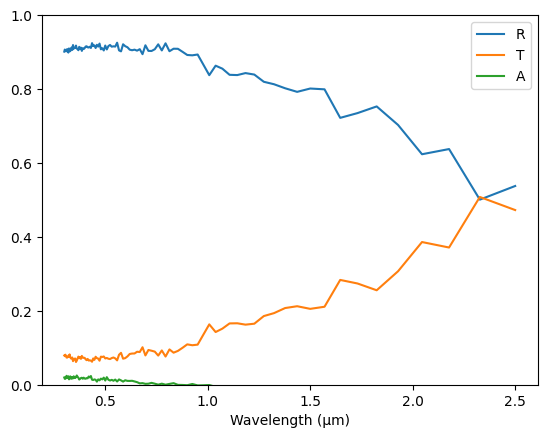

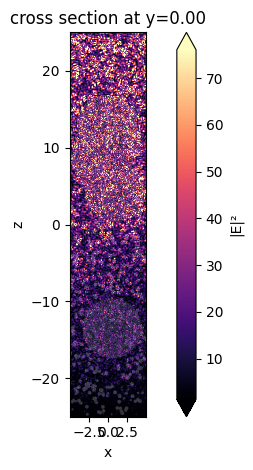

In [10]:
#Result Visualization
R = sim_data["R"].flux
T = -sim_data["T"].flux
A = 1 - R - T
plt.plot(td.C_0 /freqs, R, td.C_0 /freqs, T, td.C_0 /freqs, A)
np.savetxt('data/R_0.3-2.5um.txt', (np.transpose((td.C_0 /freqs, R))))

plt.xlabel("Wavelength (μm)")
plt.ylim(0, 1)
plt.legend(("R", "T", "A"))
plt.show()

sim_data.plot_field(field_monitor_name="field", field_name="E", val="abs^2")
plt.show()